## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere


import sfacts as sf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
species_id = 102163

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 1e-3

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 3528, 'position': 10229, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(0.006266, dtype=float32)
Coordinates:
    species_id  int64 102163
Frozen(SortedKeysDict({'strain': 178, 'sample': 3528, 'position': 10229, 'allele': 2}))


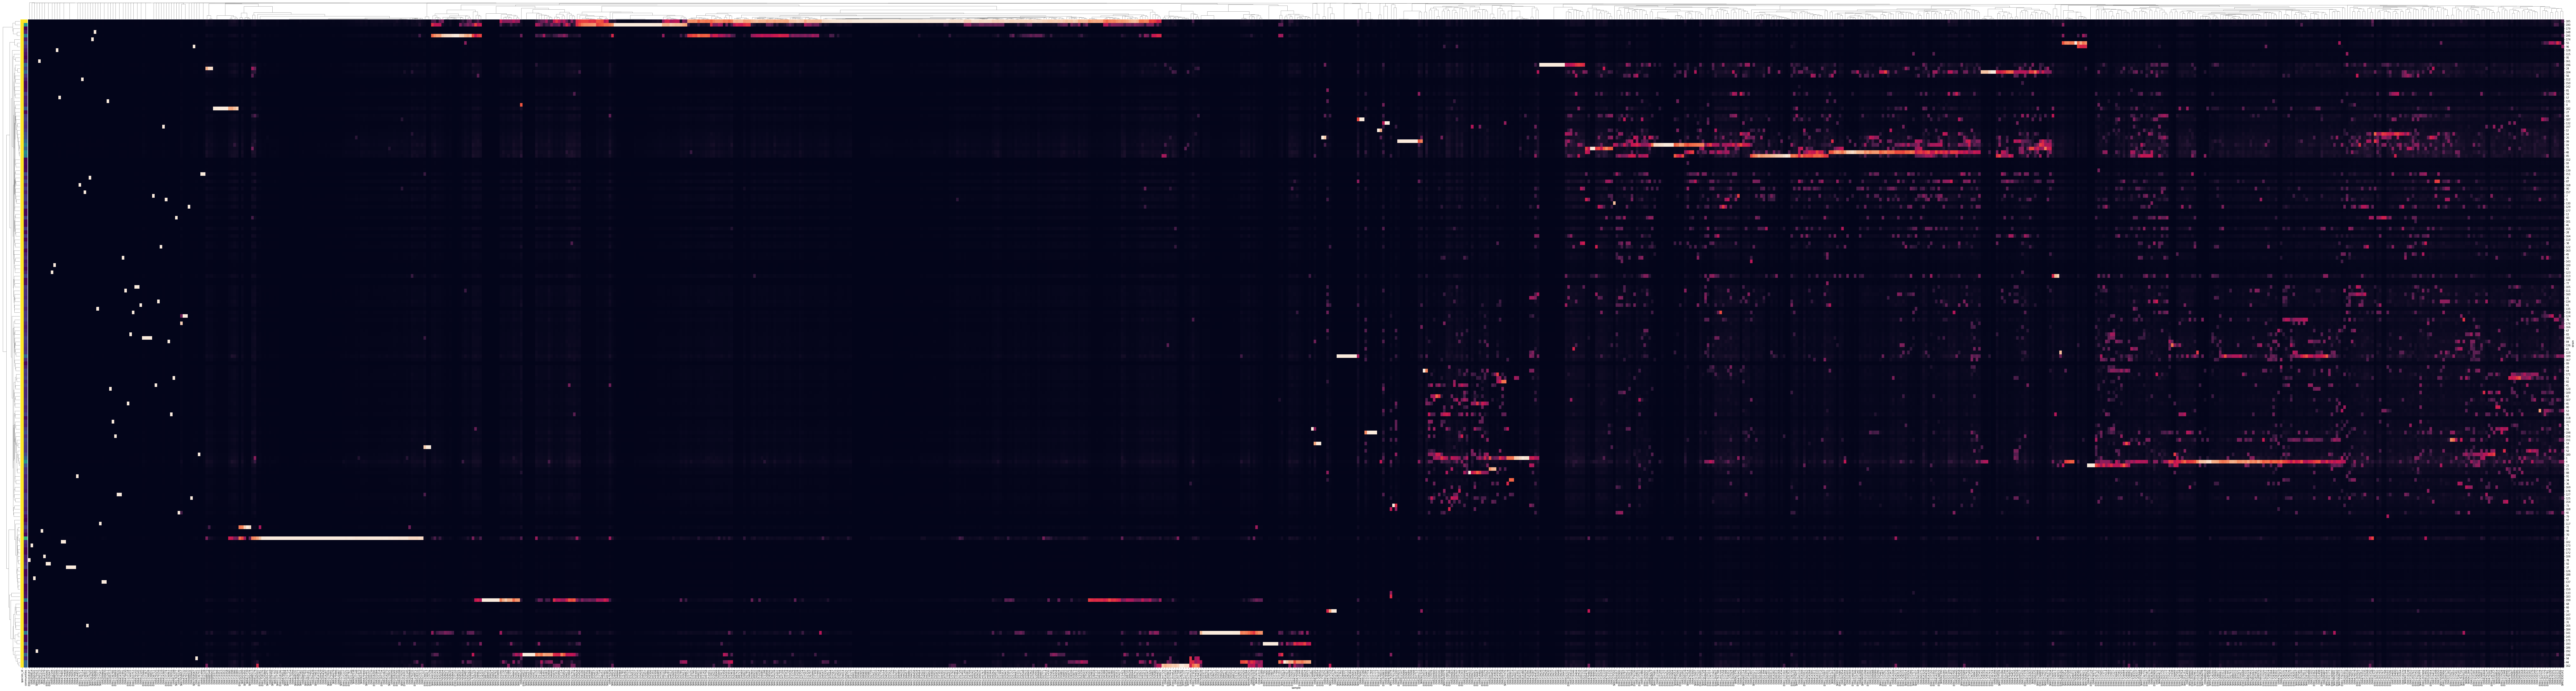

In [6]:
sf.plot_community(fit.random_sample(sample=1000), row_linkage_func=lambda w: w.genotypes.linkage("strain"))

In [7]:
ref = sf.data.Metagenotypes.load(f'data/gtprodb.sp-{species_id}.genotype.nc')
ref = ref.mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 506, 'position': 10229})

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


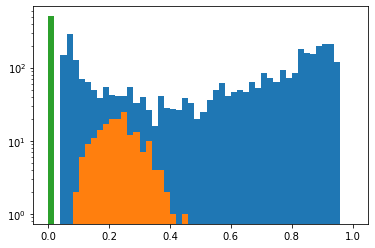

In [8]:
bins = np.linspace(0, 1, num=51)

plt.hist(fit.metagenotypes.to_estimated_genotypes(pseudo=1e-3).entropy(), bins=bins)
plt.hist(fit.genotypes.entropy(), bins=bins)
plt.hist(ref.entropy(), bins=bins)

plt.yscale('log')
None

In [9]:
genotype_entropy_thresh = 0.30

fit_genotypes_filt = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() < genotype_entropy_thresh)
fit_genotypes_highent = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() > genotype_entropy_thresh)

fit_genotypes_filt.sizes, fit_genotypes_highent.sizes

(Frozen({'strain': 149, 'position': 10229}),
 Frozen({'strain': 29, 'position': 10229}))

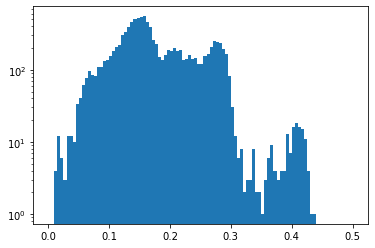

In [10]:
plt.hist(squareform(fit_genotypes_filt.pdist()), bins=np.linspace(0, 0.5, num=101))
plt.yscale('log')
None

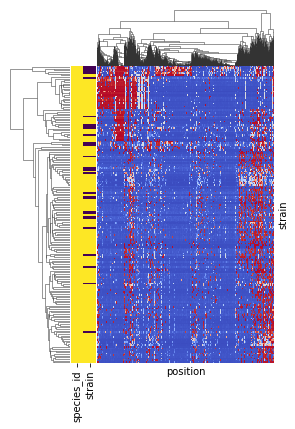

In [11]:
g = sf.data.Genotypes.concat(dict(
    bad=fit_genotypes_highent,
    good=fit_genotypes_filt
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=2500), row_colors_func=lambda w: w.strain.str.startswith('good'), scaley=2e-2, scalex=1e-3, yticklabels=0)

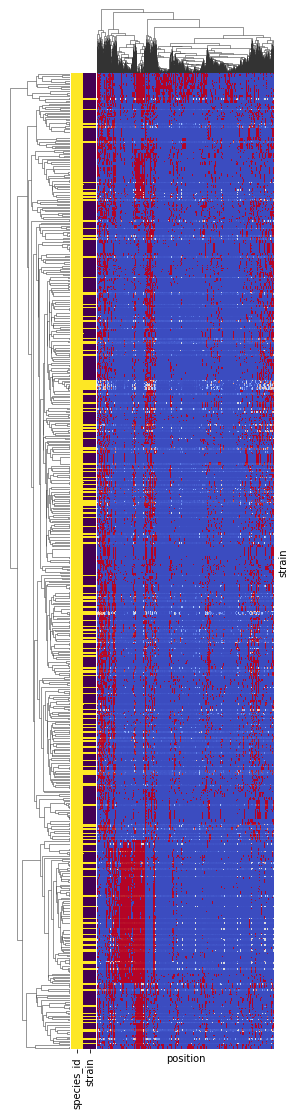

In [12]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=2500), row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=2e-2, scalex=1e-3, yticklabels=0)

In [13]:
position_meta = pd.read_table(
    'ref/gtpro/variants_main.covered.hq.snp_dict.tsv',
    names=['species_id', 'position', 'contig', 'contig_position', 'ref', 'alt']
).set_index('position')[lambda x: x.species_id.isin([species_id])]

position_meta

,species_id,contig,contig_position,ref,alt
position,,,,,
94,102163,NODE_78_length_173916_cov_6.54907,94,G,T
153,102163,NODE_78_length_173916_cov_6.54907,153,C,A
159,102163,NODE_78_length_173916_cov_6.54907,159,C,T
164,102163,NODE_78_length_173916_cov_6.54907,164,G,A
169,102163,NODE_78_length_173916_cov_6.54907,169,T,G
...,...,...,...,...,...
1801376,102163,NODE_6035_length_8232_cov_7.33472,2936,G,A
1801377,102163,NODE_6035_length_8232_cov_7.33472,2937,G,A
1801378,102163,NODE_6035_length_8232_cov_7.33472,2938,C,T


In [14]:
ref_diss = ref.pdist("strain")
ref_clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.02, affinity='precomputed', linkage='complete').fit_predict(ref_diss)
ref_clust = pd.Series(ref_clust, index=ref_diss.index)
ref_clust.value_counts()

85     6
171    5
46     5
13     5
39     5
      ..
180    1
179    1
178    1
177    1
414    1
Length: 415, dtype: int64

In [15]:
ref_agg = sf.data.Genotypes(
    ref.data.to_dataframe().join(ref_clust.rename("clust")).reset_index().groupby(["clust", "position"]).mean().rename_axis(index=dict(clust='strain')).squeeze().to_xarray()
)

In [16]:
ld = {}
for contig, pos in position_meta.loc[ref_agg.position].groupby('contig'):
    print(contig)
    g = ref_agg.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
ref_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

NODE_1054_length_36823_cov_6.16223
NODE_132_length_137177_cov_6.73742
NODE_134_length_136396_cov_6.73895
NODE_1456_length_28474_cov_5.90513
NODE_150_length_130231_cov_6.82106
NODE_1931_length_22763_cov_5.89686
NODE_2212_length_20034_cov_6.74208
NODE_225_length_101993_cov_6.4074
NODE_291_length_87397_cov_6.7277
NODE_305_length_85773_cov_5.88231
NODE_425_length_71300_cov_6.00556
NODE_428_length_70861_cov_6.75133
NODE_471_length_65793_cov_7.1706
NODE_502_length_63169_cov_6.98056
NODE_514_length_62055_cov_6.35881
NODE_5864_length_8442_cov_6.77298
NODE_6035_length_8232_cov_7.33472
NODE_667_length_51666_cov_6.68154
NODE_771_length_45969_cov_6.56273
NODE_78_length_173916_cov_6.54907
NODE_845_length_43304_cov_5.71937
NODE_883_length_41784_cov_6.37156
NODE_90_length_165920_cov_6.3587


In [17]:
est_diss = fit_genotypes_filt.pdist("strain")
est_clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.02, affinity='precomputed', linkage='complete').fit_predict(est_diss)
est_clust = pd.Series(est_clust, index=est_diss.index)
est_clust.value_counts()

0      2
2      2
3      2
1      2
100    1
      ..
43     1
42     1
41     1
40     1
144    1
Length: 145, dtype: int64

In [18]:
est_agg = sf.data.Genotypes(
    fit_genotypes_filt.data.to_dataframe().join(est_clust.rename("clust")).reset_index().groupby(["clust", "position"]).mean().genotypes.rename_axis(index=dict(clust='strain')).to_xarray()
)

In [19]:
ld = {}
for contig, pos in position_meta.loc[est_agg.position].groupby('contig'):
    print(contig)
    g = est_agg.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
est_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

NODE_1054_length_36823_cov_6.16223
NODE_132_length_137177_cov_6.73742
NODE_134_length_136396_cov_6.73895
NODE_1456_length_28474_cov_5.90513
NODE_150_length_130231_cov_6.82106
NODE_1931_length_22763_cov_5.89686
NODE_2212_length_20034_cov_6.74208
NODE_225_length_101993_cov_6.4074
NODE_291_length_87397_cov_6.7277
NODE_305_length_85773_cov_5.88231
NODE_425_length_71300_cov_6.00556
NODE_428_length_70861_cov_6.75133
NODE_471_length_65793_cov_7.1706
NODE_502_length_63169_cov_6.98056
NODE_514_length_62055_cov_6.35881
NODE_5864_length_8442_cov_6.77298
NODE_6035_length_8232_cov_7.33472
NODE_667_length_51666_cov_6.68154
NODE_771_length_45969_cov_6.56273
NODE_78_length_173916_cov_6.54907
NODE_845_length_43304_cov_5.71937
NODE_883_length_41784_cov_6.37156
NODE_90_length_165920_cov_6.3587


Text(0, 0.5, 'LD ($R^2$)')

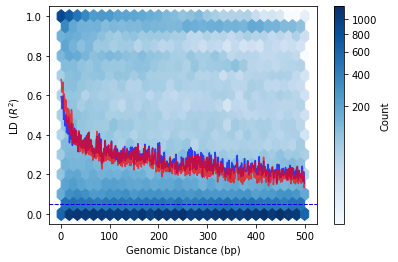

In [22]:
stepsize = 1
right = 500

d = est_ld[lambda p: p.x < right]
bins_est = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_est[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()
    
    
d = ref_ld[lambda p: p.x < right]
bins_ref = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_ref[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()


fig = plt.figure()

plt.hexbin('x', 'r2', data=d, cmap='Blues', norm=mpl.colors.PowerNorm(1/3), mincnt=1, gridsize=(30, 10), label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

ax.plot(pd.Series(bins_ref), color='blue', label=f'reference genotypes', alpha=0.7)
ax.plot(pd.Series(bins_est), color='red', label=f'inferred genotypes', alpha=0.7)
ax.axhline(est_ld.r2.mean(), lw=1, color='red', linestyle='--')
ax.axhline(ref_ld.r2.mean(), lw=1, color='blue', linestyle='--')


# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')